In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from tqdm.notebook import tqdm

from qsa_pwfa.simulation import Simulation as Simulation_old
from qsa_pwfa.new_methods.simulation import Simulation as Simulation_new

from qsa_pwfa.utils import get_density, get_field, get_Psi_new_grid

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
# Beam 
n_b = 5.0
R_b = 0.1
ksi0 = 5
R_xi = 1

# plasma
L_xi =  18
L_r = 10.0/4

# grid
N_xi = 512
d_xi = L_xi / N_xi

dr = 0.03 * d_xi
N_r = int(np.ceil(L_r/dr / 4)*4)
L_r = N_r * dr

#N_r = 2048
#dr = L_r / N_r

n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12

59.87392327012325

In [3]:
add_args = [
    {'iter_max':0, 'add_mag_force':True},
    {'correct_Psi':True, 'correct_vz':True}, 
]

sim_old = Simulation_old(L_xi=L_xi, N_xi=N_xi, 
                         L_r=L_r, N_r=N_r, 
                         dens_func=lambda r: 1 )
sim_old.init_beam(n_b, R_b, ksi0, R_xi)

sim_new = Simulation_new(L_xi=L_xi, N_xi=N_xi,
                         L_r=L_r, N_r=N_r, 
                         dens_func=lambda r: 1 )
sim_new.init_beam(n_b, R_b, ksi0, R_xi)


sims = [sim_new, sim_old]
#sims = [sim_new,]

sims[0].advance_xi(**add_args[0])

  0%|          | 0/511 [00:00<?, ?it/s]

/home/andriyash/mambaforge/lib/python3.9/site-packages/qsa_pwfa/new_methods/simulation.py:119: RuntimeWarning: divide by zero encountered in true_divide
  self.d2r_dxi2[:] = ( self.F / (1. - self.v_z) \
/home/andriyash/mambaforge/lib/python3.9/site-packages/qsa_pwfa/new_methods/simulation.py:94: RuntimeWarning: invalid value encountered in true_divide
  self.v_z[:] = (self.T - 1.) / (self.T + 1.)
/home/andriyash/mambaforge/lib/python3.9/site-packages/qsa_pwfa/new_methods/simulation.py:111: RuntimeWarning: invalid value encountered in multiply
  self.F[:] = self.F_part + (1. - self.v_z) * self.dAr_dxi


<IPython.core.display.Javascript object>


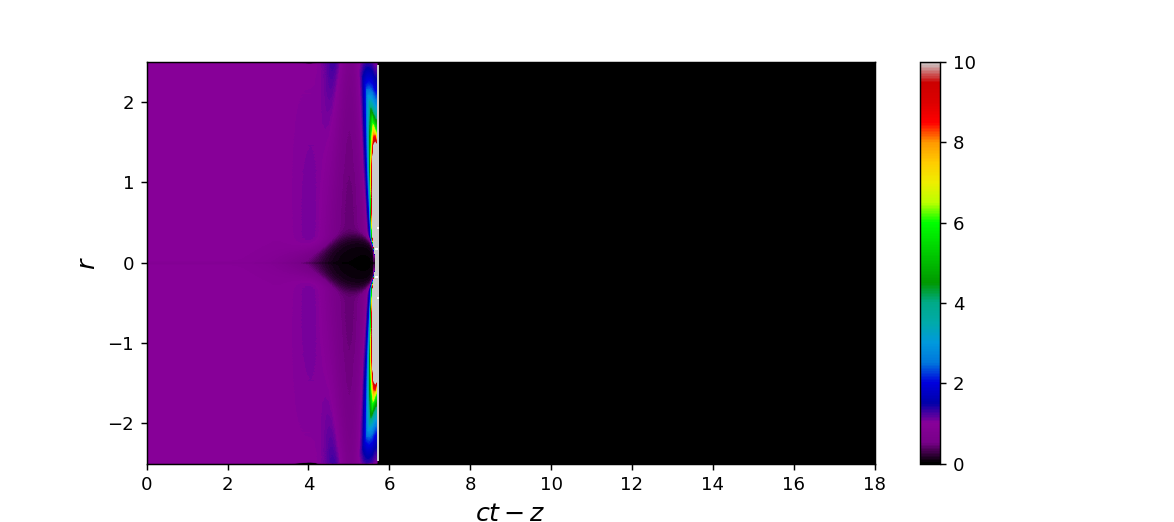

  0%|          | 0/511 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


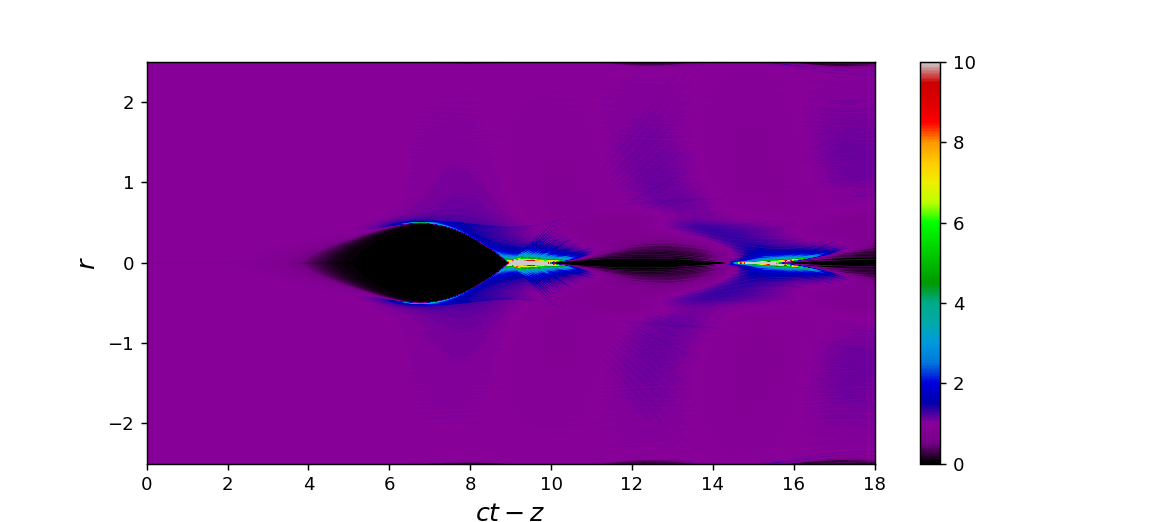

In [4]:
for i_sim, sim in enumerate(sims):

    r_xi = np.zeros((sim.N_xi, sim.N_r))
    vz_xi = np.zeros((sim.N_xi, sim.N_r))
    phi_xi = np.zeros((sim.N_xi, sim.N_r))
    dAr_dxi_xi = np.zeros((sim.N_xi, sim.N_r))
    force_xi = np.zeros((sim.N_xi, sim.N_r))

    r_xi[0] = sim.r
    vz_xi[0] = sim.v_z

    for i_xi in tqdm(range(N_xi-1)):
        sim.advance_xi(**add_args[i_sim])
        r_xi[i_xi+1] = sim.r
        vz_xi[i_xi+1] = sim.v_z
        phi_xi[i_xi+1] = sim.Psi
        dAr_dxi_xi[i_xi+1] = sim.dAr_dxi
        force_xi[i_xi+1] = sim.F

    Nr_new = sim.N_r//2
    dr_proj = L_r/Nr_new
    ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) # * k_p_inv * 1e6

    dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    val = dens
    val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

    plt.figure(figsize=(9,4))

    vmax = np.abs( val.max() )    
    plt.imshow(val_ext.T, origin='lower', 
               aspect='auto', cmap=plt.cm.nipy_spectral,
               vmax=10, 
               #vmax=vmax, vmin=-vmax,
               extent=ext)
    plt.colorbar()
    plt.xlabel(r'$ct-z$', fontsize=14)
    plt.ylabel(r'$r$', fontsize=14)    